In [3]:
import numpy as np

results = np.load('training_strategies_comparisonV6.npy', allow_pickle=True).item()

In [4]:
import sys
sys.path.append("../")
import numpy as np
import h5py
import torch as pt
from tqdm import tqdm
import matplotlib.pyplot as plt
from LSTM_construction import CTLSTM
import os

def create_comparison_plots(all_results, num_buckets, epochs_per_bucket):
    """
    Crée les graphiques de comparaison globaux et par bucket
    """
    strategies = list(all_results.keys())
    colors = ['yellow','red', 'green','blue']
    
    # =====================================================================
    # 1. GRAPHIQUES GLOBAUX (comparaison générale)
    # =====================================================================
    fig_global, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Graphique 1: Train Loss per Event
    ax1.set_title('Training Loss per Event - Global Comparison', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Train Loss per Event')
    ax1.grid(True, alpha=0.3)
    
    for i, strategy in enumerate(strategies):
        train_losses = all_results[strategy]['train_losses_per_event']
        epochs = range(1, len(train_losses) + 1)
        if strategy == 'Progressive Random':
            esm='Progressive Random'
        elif strategy == 'Curriculum Learning':
            esm='Sequence length based Curriculum Learning'
        elif strategy == 'Random Buckets':
            esm='Random Buckets'
        elif strategy == 'Curriculum LearningV2':
            esm='Loss based Curriculum Learning'
           
        ax1.plot(epochs, train_losses, color=colors[i], linewidth=2, label=esm, marker='o', markersize=4)
    
    # Ajouter des lignes verticales pour séparer les buckets
    for bucket in range(1, num_buckets):
        ax1.axvline(x=bucket * epochs_per_bucket, color='gray', linestyle='--', alpha=0.5)
    
    ax1.legend()
    ax1.set_yscale('log')  # Échelle logarithmique pour mieux voir les différences
    
    # Graphique 2: Validation Loss per Event
    ax2.set_title('Validation Loss per Event - Global Comparison', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Validation Loss per Event')
    ax2.grid(True, alpha=0.3)
    
    for i, strategy in enumerate(strategies):
        val_losses = all_results[strategy]['val_losses_per_event']
        epochs = range(1, len(val_losses) + 1)
        if strategy == 'Progressive Random':
            esm='Progressive Random'
        elif strategy == 'Curriculum Learning':
            esm='Sequence length based Curriculum Learning'
        elif strategy == 'Random Buckets':
            esm='Random Buckets'
        elif strategy == 'Curriculum LearningV2':
            esm='Loss based Curriculum Learning'        
        ax2.plot(epochs, val_losses, color=colors[i], linewidth=2, label=esm, marker='s', markersize=4)
    
    # Ajouter des lignes verticales pour séparer les buckets
    for bucket in range(1, num_buckets):
        ax2.axvline(x=bucket * epochs_per_bucket, color='gray', linestyle='--', alpha=0.5)
    
    ax2.legend()
    ax2.set_yscale('log')  # Échelle logarithmique
    
    plt.tight_layout()
    plt.savefig('training_strategies_global_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # =====================================================================
    # 2. GRAPHIQUES SÉPARÉS PAR BUCKET (chaque bucket = un fichier)
    # =====================================================================
    
    for bucket_idx in range(num_buckets):
        # Calculer les indices pour ce bucket
        start_epoch = bucket_idx * epochs_per_bucket
        end_epoch = (bucket_idx + 1) * epochs_per_bucket
        
        # Créer une figure pour ce bucket spécifique
        fig_bucket, (ax_train, ax_val) = plt.subplots(1, 2, figsize=(15, 6))
        fig_bucket.suptitle(f'Bucket {bucket_idx+1} - Training Strategies Comparison', fontsize=16, fontweight='bold')
        
        # Axe pour Train Loss
        ax_train.set_title(f'Training Loss per Event', fontsize=14, fontweight='bold')
        ax_train.set_xlabel('Epoch within Bucket')
        ax_train.set_ylabel('Train Loss per Event')
        ax_train.grid(True, alpha=0.3)
        
        # Axe pour Validation Loss
        ax_val.set_title(f'Validation Loss per Event', fontsize=14, fontweight='bold')
        ax_val.set_xlabel('Epoch within Bucket')
        ax_val.set_ylabel('Validation Loss per Event')
        ax_val.grid(True, alpha=0.3)
        
        # Tracer les courbes pour chaque stratégie
        for i, strategy in enumerate(strategies):
            esm = strategy
            if strategy == 'Progressive Random':
                esm = 'Progressive Random'
            elif strategy == 'Curriculum Learning':
                esm = 'Sequence length based Curriculum Learning'
            elif strategy == 'Random Buckets':
                esm = 'Random Buckets'
            elif strategy == 'Curriculum LearningV2':
                esm = 'Loss based Curriculum Learning'
            train_losses = all_results[strategy]['train_losses_per_event'][start_epoch:end_epoch]
            val_losses = all_results[strategy]['val_losses_per_event'][start_epoch:end_epoch]
            epochs_in_bucket = range(1, len(train_losses) + 1)
            
            # Train loss
            ax_train.plot(epochs_in_bucket, train_losses, color=colors[i], linewidth=3, 
                         label=esm, marker='o', markersize=8)
            
            # Validation loss
            ax_val.plot(epochs_in_bucket, val_losses, color=colors[i], linewidth=3, 
                       label=esm, marker='s', markersize=8)
        
        # Ajouter les légendes
        ax_train.legend(fontsize=12)
        ax_val.legend(fontsize=12)
        
        # Échelle logarithmique
        ax_train.set_yscale('log')
        ax_val.set_yscale('log')
        
        # Sauvegarder le graphique pour ce bucket
        plt.tight_layout()
        filename = f'bucket_{bucket_idx+1}_comparison.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"Graphique sauvegardé: {filename}")
    
    # =====================================================================
    # 3. TABLEAU DE STATISTIQUES FINALES
    # =====================================================================
    print("\n" + "="*80)
    print("RÉSULTATS FINAUX")
    print("="*80)
    
    for strategy in strategies:
        train_final = all_results[strategy]['train_losses_per_event'][-1]
        val_final = all_results[strategy]['val_losses_per_event'][-1]
        print(f"{strategy}:")
        print(f"  Train Loss per Event final: {train_final:.6f}")
        print(f"  Validation Loss per Event final: {val_final:.6f}")
    
    # Statistiques par bucket
    print("\n" + "="*80)
    print("RÉSULTATS PAR BUCKET")
    print("="*80)
    
    for bucket_idx in range(num_buckets):
        print(f"\nBucket {bucket_idx+1}:")
        start_epoch = bucket_idx * epochs_per_bucket
        end_epoch = (bucket_idx + 1) * epochs_per_bucket
        
        for strategy in strategies:
            train_bucket = all_results[strategy]['train_losses_per_event'][start_epoch:end_epoch]
            val_bucket = all_results[strategy]['val_losses_per_event'][start_epoch:end_epoch]
            
            print(f"  {strategy}:")
            print(f"    Train Loss - Start: {train_bucket[0]:.6f}, End: {train_bucket[-1]:.6f}, Improvement: {((train_bucket[0]-train_bucket[-1])/train_bucket[0]*100):.2f}%")
            print(f"    Val Loss   - Start: {val_bucket[0]:.6f}, End: {val_bucket[-1]:.6f}, Improvement: {((val_bucket[0]-val_bucket[-1])/val_bucket[0]*100):.2f}%")
    print()

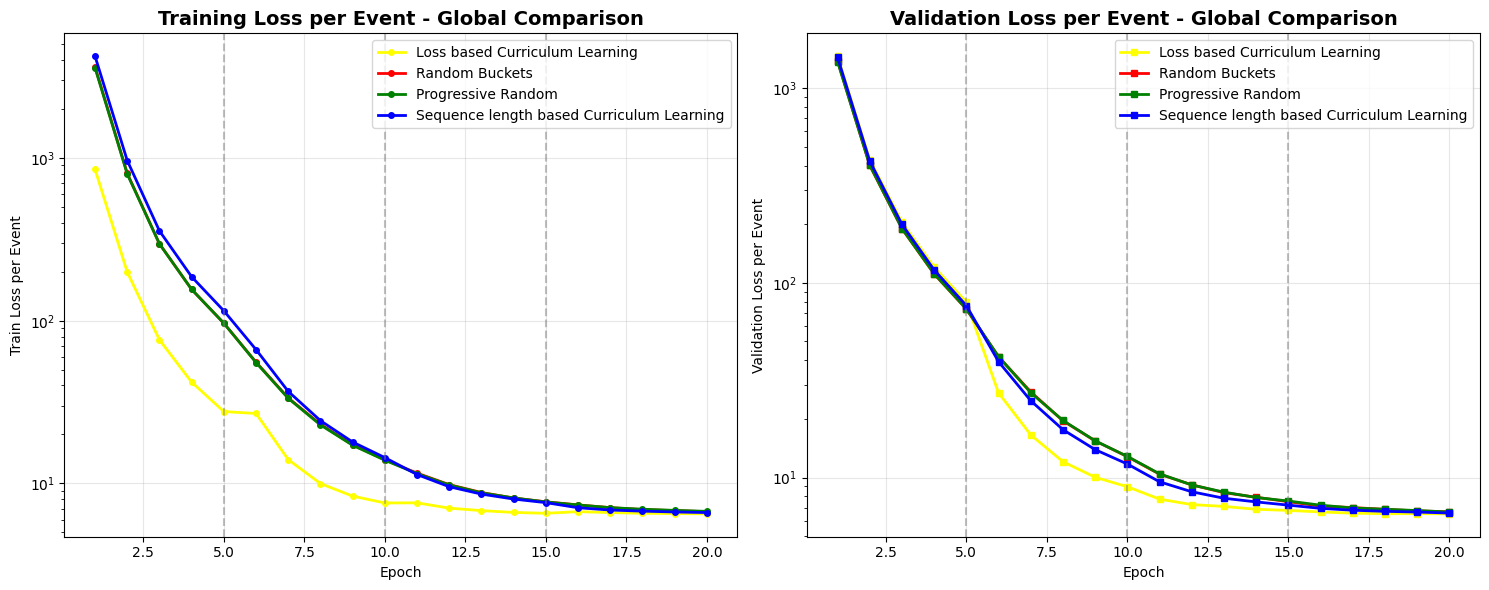

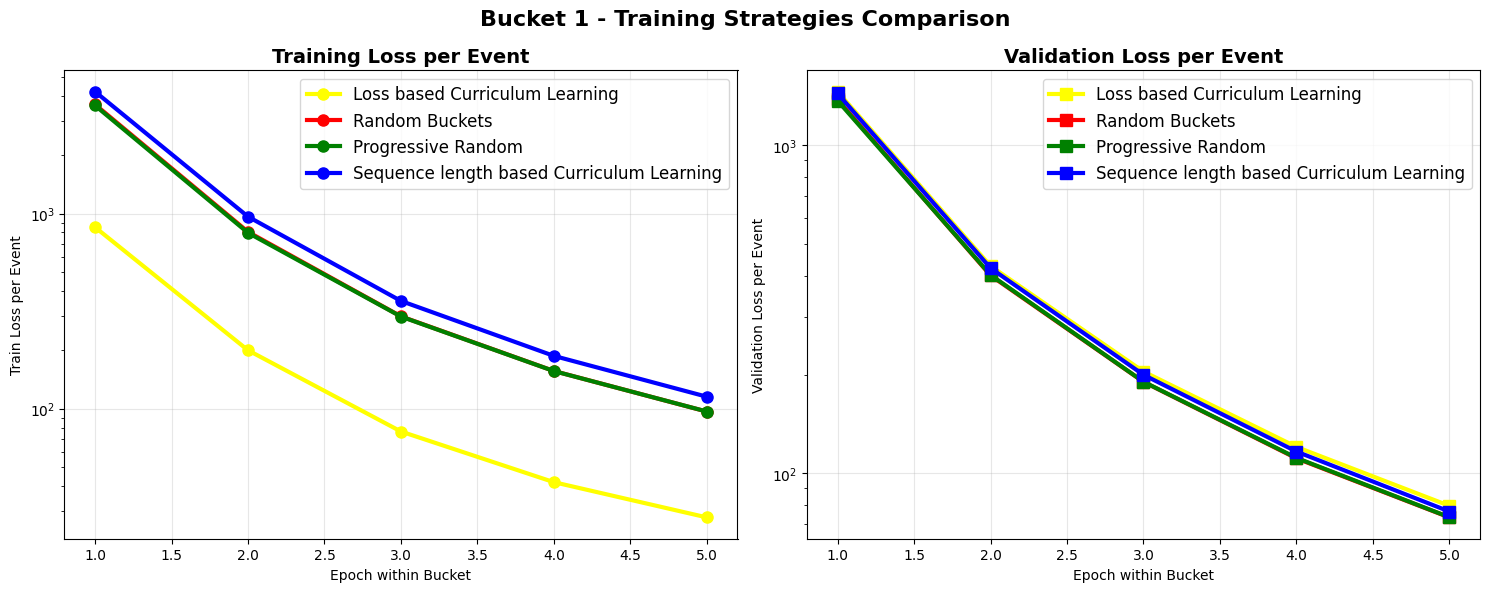

Graphique sauvegardé: bucket_1_comparison.png


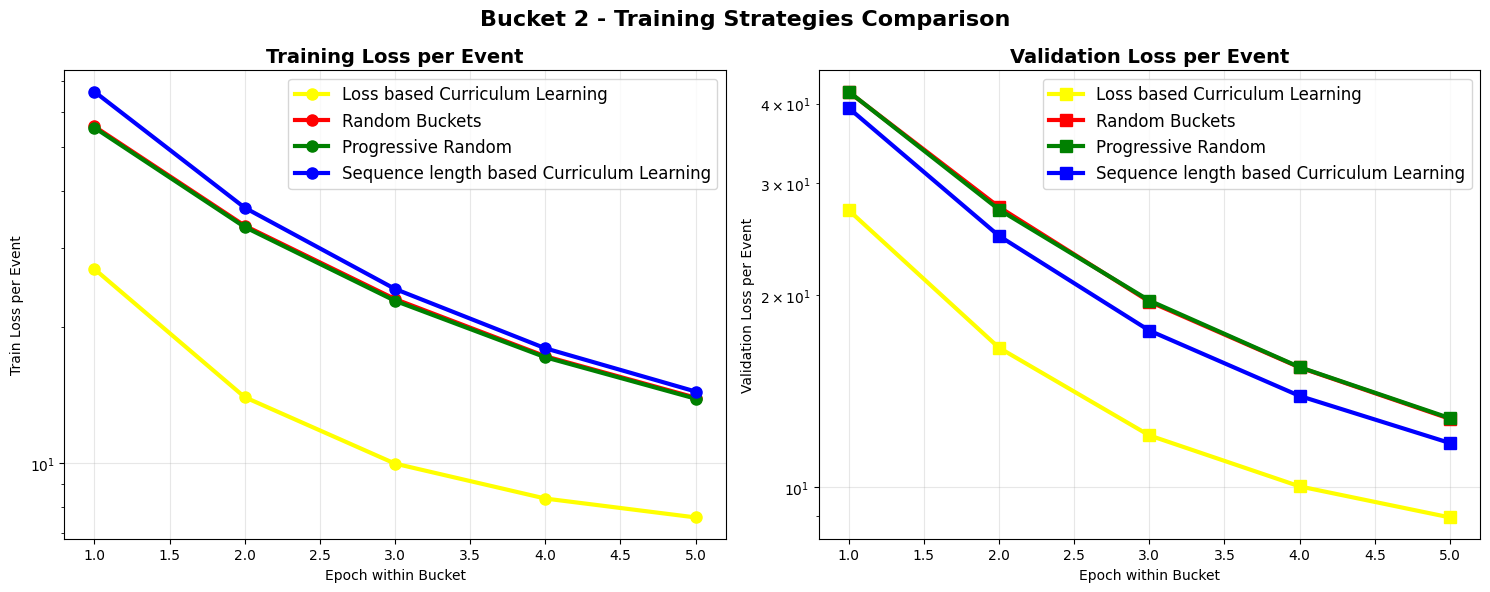

Graphique sauvegardé: bucket_2_comparison.png


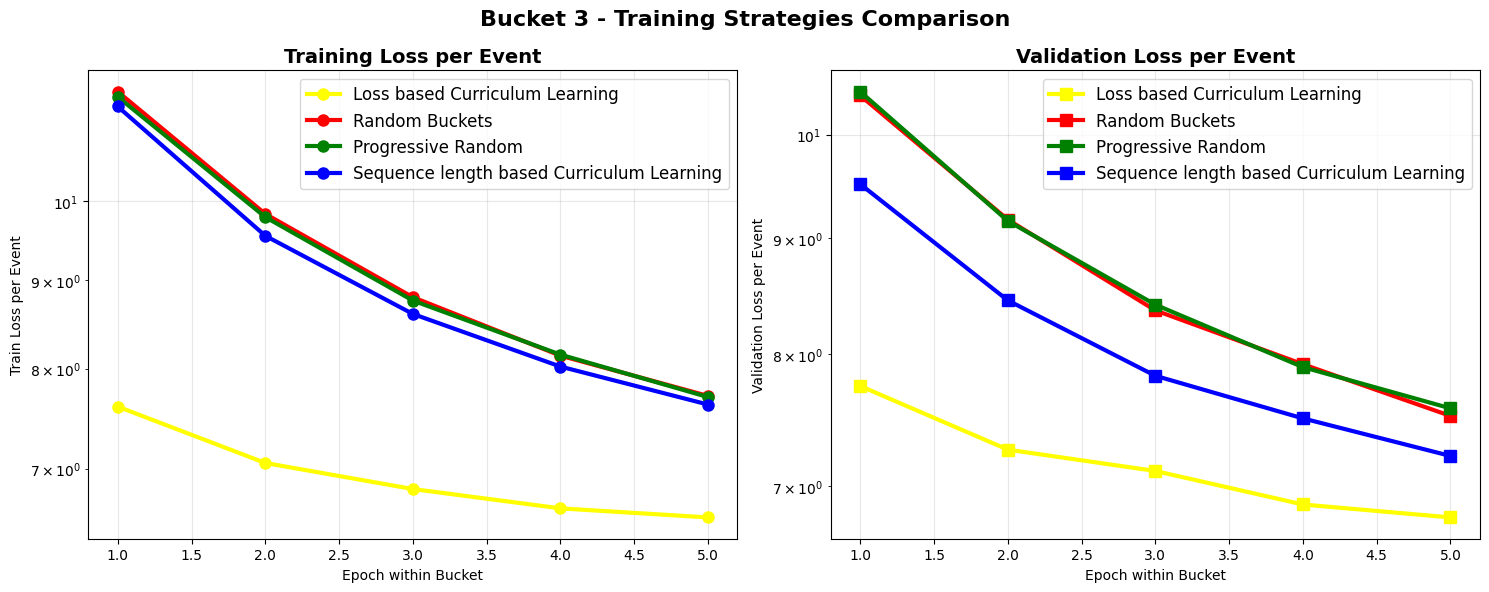

Graphique sauvegardé: bucket_3_comparison.png


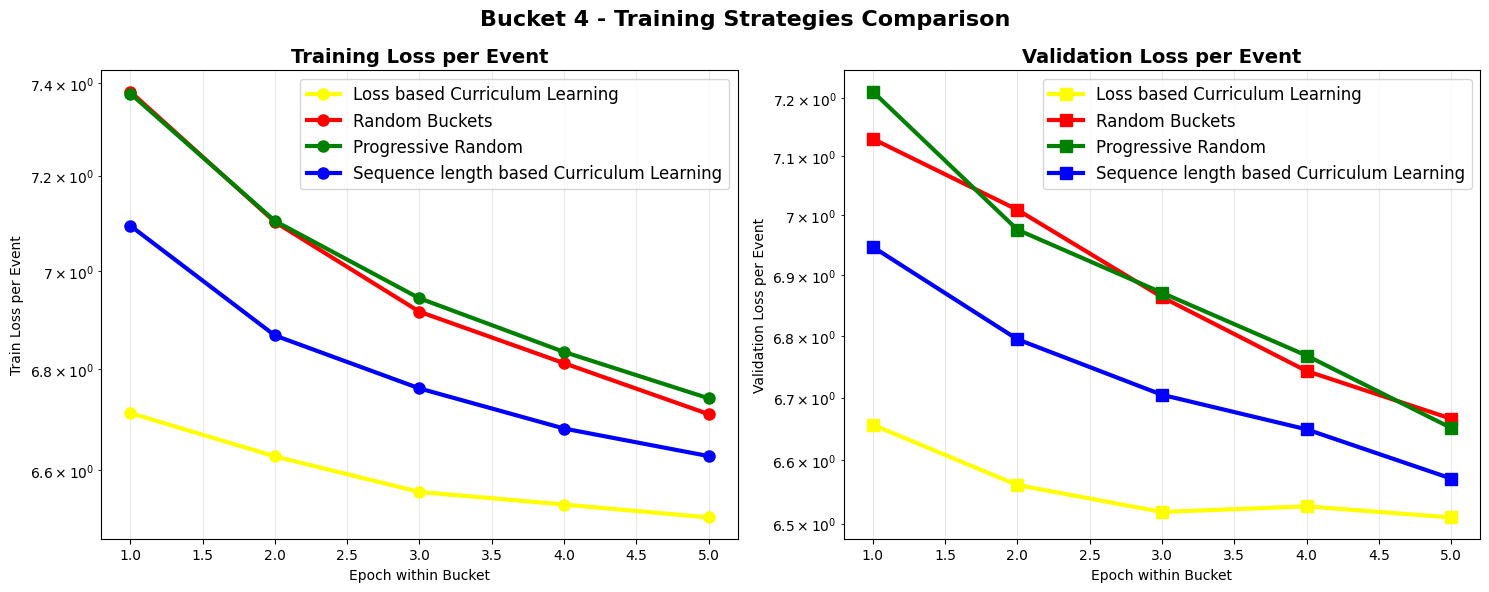

Graphique sauvegardé: bucket_4_comparison.png

RÉSULTATS FINAUX
Curriculum LearningV2:
  Train Loss per Event final: 6.507782
  Validation Loss per Event final: 6.509722
Random Buckets:
  Train Loss per Event final: 6.709616
  Validation Loss per Event final: 6.666059
Progressive Random:
  Train Loss per Event final: 6.741092
  Validation Loss per Event final: 6.651325
Curriculum Learning:
  Train Loss per Event final: 6.626893
  Validation Loss per Event final: 6.570908

RÉSULTATS PAR BUCKET

Bucket 1:
  Curriculum LearningV2:
    Train Loss - Start: 851.159020, End: 27.667263, Improvement: 96.75%
    Val Loss   - Start: 1458.094311, End: 79.517932, Improvement: 94.55%
  Random Buckets:
    Train Loss - Start: 3625.876209, End: 96.501975, Improvement: 97.34%
    Val Loss   - Start: 1380.505983, End: 73.312328, Improvement: 94.69%
  Progressive Random:
    Train Loss - Start: 3582.795700, End: 96.559615, Improvement: 97.30%
    Val Loss   - Start: 1368.625016, End: 73.416064, Improveme

In [5]:
create_comparison_plots(results, 4, 5)